# Libraries

In [1]:
import sys
sys.path.append("../")

In [2]:
# for working with data
import pandas as pd
import numpy as np
from src.data_exploration import explore_functions as explr

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)

# warning
import warnings 
warnings.filterwarnings('ignore') 

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("Set2")

# for preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from feature_engine.encoding import WoEEncoder
from imblearn.over_sampling import SMOTE

# for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# for evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score

# for tuning
import optuna
import joblib

In [3]:
def check_balance(data, target, chart_types="pie", normalize=True, positive_target=0):
    target_counts = data[target].value_counts()
    target_counts.index = ["non-default" if i==positive_target else "default" for i in target_counts.index] 
    # sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index)
    if chart_types == "pie":
        plt.pie(target_counts.values, labels=target_counts.index, normalize=normalize, startangle=90,
            autopct="%1.1f%%", explode=[0, 0.1])
    elif chart_types == "bar":
        sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index, palette="tab10")
        plt.xlabel("Targets")
    plt.title("Distribution of Targets")

def distribution_barplot(data, feature, normalize=True, title=None, legend="auto", labels=None):
    feature_count = data[feature].value_counts(normalize=normalize).reset_index()
    sns.barplot(x=feature_count[feature], y=feature_count.iloc[:, 1], hue=feature_count.iloc[:, 0],
                palette="Set2", legend=legend)      
    plt.xlabel(feature)
    plt.title(f"Distribution of {feature}")

def distitribution_otherbased(data, dist_feature, base_feature, normalize=False):
    dist = data.groupby(by=base_feature, as_index=False)[dist_feature].value_counts(normalize=normalize)
    sns.barplot(x=dist[base_feature], y=dist.iloc[:, -1], hue=dist[dist_feature])
    if normalize:
        plt.ylim(0, 1.05)

# Load Data

In [4]:
data_org = pd.read_csv("../data/taiwan_default_payments.csv")
data_org.head()

,default,id,limit_bal,gender,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,1,1,20000,female,university,married,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,1,2,120000,female,university,single,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,0,3,90000,female,university,single,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,0,4,50000,female,university,married,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,0,5,50000,male,university,married,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


# Train Test Split

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data_org.iloc[:, 1:], data_org.iloc[:, 0], test_size=0.2,
                                                    shuffle=True, random_state=42)
print(f"Training Set: {x_train.shape[0]} observations")
print(f"Testing Set: {x_test.shape[0]} observations")

Training Set: 24000 observations
Testing Set: 6000 observations


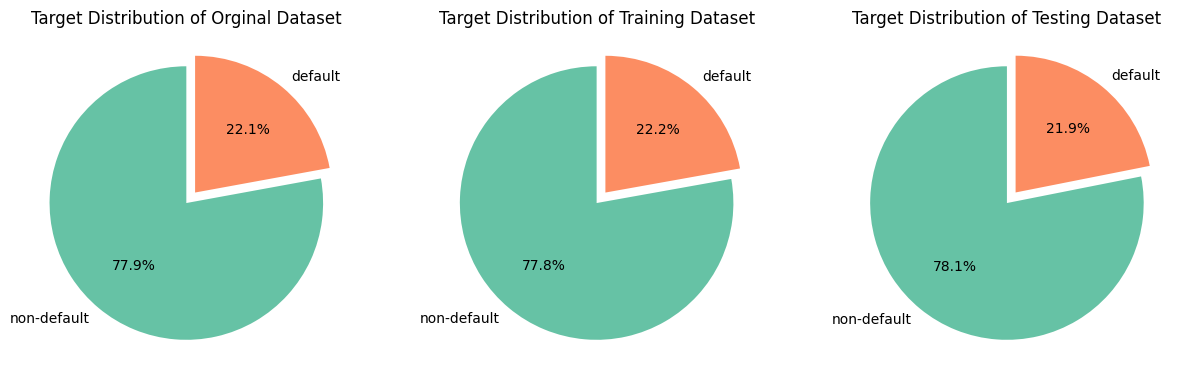

In [6]:
plt.figure(figsize=(15, 5))
dataset = [data_org, pd.DataFrame(y_train), pd.DataFrame(y_test)]
titles = ["Target Distribution of Orginal Dataset",
          "Target Distribution of Training Dataset",
          "Target Distribution of Testing Dataset"]
for i in range(3):
    plt.subplot(1, 3, i+1)
    check_balance(data=dataset[i], target="default")
    plt.title(titles[i])

# Preprocessing

In [7]:
class WoE:
    def __init__(self, bins=5, handle_numeric=True):
        # self.encoded = {}
        # self.dist_class = {}
        # self.feature_name = None
        # self.information_value = {}
        self.bins = bins
        # self.num_fea_bins = {}
        self.handle_numeric = handle_numeric

    def fit(self, X, y):
        data = pd.concat([X, y], axis=1)
        target_name = y.name
        target_count = data[target_name].value_counts().to_dict()

        # fit
        self.feature_name = []
        self.encoded = {}
        self.dist_class = {}
        self.information_value = {}
        self.num_fea_bins = {}

        if self.handle_numeric:
            num_fea = data.iloc[:, :-1].select_dtypes(exclude="object")
            bins = self.bins
            for col in num_fea.columns:
                self.num_fea_bins[col] = self.create_bins(data[col], bins=bins)
                data[col] = self.convert_into_bins(data[[col]], col, self.num_fea_bins[col])
            columns = data.columns[:-1]
        else:
            columns = data.select_dtypes(include="object").columns

        for col in columns:
            self.feature_name.append(col)
            col_value = data.groupby(col)[target_name].value_counts().to_dict()
            self.dist_class[col] = {}
            for key, value in col_value.items():
                if key[0] not in self.dist_class[col]:
                    self.dist_class[col][key[0]] = {key[1]: value/target_count[key[1]]}
                else:
                    self.dist_class[col][key[0]][key[1]] = value/target_count[key[1]]
            encoded = {}
            iv = 0
            for value, dist_class in self.dist_class[col].items():
                if 0 not in dist_class:
                    self.dist_class[col][value][0] = 0.00001
                if 1 not in dist_class:
                    self.dist_class[col][value][1] = 0.00001
                dist_0 = self.dist_class[col][value][0]
                dist_1 = self.dist_class[col][value][1]
                woe = np.log(dist_0/dist_1)

                encoded[value] = woe
                iv += (dist_0 - dist_1) * encoded[value]

            self.encoded[col] = encoded
            self.information_value[col] = iv

        self.information_value = dict(sorted(self.information_value.items(), key=lambda x: x[1], reverse=True))

    def fit_transform(self, X, y):
        self.fit(X, y)
        data = self.transform(X)
        return data

    def transform(self, X):
        data = X.copy()
        for col, bins in self.num_fea_bins.items():
            data[col] = self.convert_into_bins(data[[col]], col, bins)

        for col in self.feature_name:
            data[col] = data[col].apply(lambda x: self.encoded[col][x] if x in self.encoded[col].keys() else 0)
        
        return data
        

    def create_bins(self, feature, bins):
        bins = pd.cut(feature, bins=bins, right=False, retbins=True)[1]
        bins_dict = {}
        for i in range(len(bins)-1):
            if i==0:
                bins_name = f"under {bins[i]}"
                lower = bins[i]-10**10
                upper = bins[i+1]
            elif i==len(bins)-2:
                bins_name = f"over {bins[i]}"
                lower = bins[i]
                upper = bins[i+1]
            else:
                bins_name = f"{bins[i]} - {bins[i+1]}"
                lower = bins[i]
                upper = bins[i+1] + 10**10
            bins_dict[(lower, upper)] = bins_name
        return bins_dict
    
    def convert_into_bins(self, X, feature, bins):
        data = X.copy()
        for bins, bins_name in bins.items():
            data.loc[data[feature].between(bins[0], bins[1], "right"), f"{feature}_bins"] = bins_name
        return data.iloc[:, -1]

    def get_feature_names_out(self):
        return self.feature_name
    
class IVSelector(WoE):
    def __init__(self, threshold=0.02, bins=3):
        super().__init__()
        self.threshold = threshold
        self.bins = bins

    def fit(self, X, y):
        super().fit(X, y)
        threshold = self.threshold
        self.drop = [col for col in self.information_value.keys() if self.information_value[col] < threshold]
        self.feature_name = [col for col in self.feature_name if col not in self.drop]
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        data = X.drop(self.drop, axis=1)
        return data

    def transform(self, X):
        data = X.drop(self.drop, axis=1)
        return data

    def get_feature_names_out(self):
        return self.feature_name

In [8]:
class Preprocessing:
    def __init__(self, scaler=None, encoder=None, numeric_to_object=None, numeric_into_bins=None, specific_encoders=None,
                 feature_selector=None):
        self.scaler = scaler
        self.encoder = encoder
        self.specific_encoders = specific_encoders
        self.num_to_obj = numeric_to_object
        self.numbins = numeric_into_bins
        self.cate_feas = None
        self.num_feas = None
        self.selector = feature_selector
    
    def fit(self, X, y):
        data = X.copy()
        if self.selector is not None:
            self.selector.fit(data, y)

        if self.num_to_obj is not None:
            data[self.num_to_obj] = data[self.num_to_obj].astype("object")
        if self.numbins is not None:
            for feature, bins in self.numbins.items():
                if not isinstance(bins, dict):
                    self.numbins[feature] = self.create_bins(data[feature], bins=bins)
                data[feature] = self.convert_into_bins(data[[feature]], feature, self.numbins[feature])

        self.cate_feas = list(data.select_dtypes(include="object").columns)
        self.num_feas = [col for col in data.columns if col not in self.cate_feas]

        if self.specific_encoders is not None:
            self.cate_feas = [col for col in self.cate_feas if col not in self.specific_encoders.keys()]
            for feature, encoder in self.specific_encoders.items():
                if not isinstance(encoder, OneHotEncoder):
                    if (isinstance(encoder, WoEEncoder)) or (isinstance(encoder, WoE)):
                        self.specific_encoders[feature].fit(X=data[feature], y=y)
                    else:
                        self.specific_encoders[feature].fit(data[feature])
                else:
                    self.specific_encoders[feature].fit(data[[feature]])

        if self.scaler is not None:
            self.scaler.fit(data[self.num_feas])

        if self.encoder is not None:
            if (isinstance(self.encoder, WoEEncoder)) or (isinstance(self.encoder, WoE)):
                self.encoder.fit(X=data[self.cate_feas], y=y)
            else:
                self.encoder.fit(data[self.cate_feas])

    def fit_transform(self, X, y):
        self.fit(X, y)
        data = self.transform(X)
        return data

    def transform(self, X):
        data = X.copy()

        if self.num_to_obj is not None:
            data[self.num_to_obj] = data[self.num_to_obj].astype("object")
        if self.numbins is not None:
            for feature in self.numbins.keys():
                data[feature] = self.convert_into_bins(data[[feature]], feature, self.numbins[feature])

        if self.specific_encoders is not None:
            for feature, encoder in self.specific_encoders.items():
                if isinstance(encoder, OneHotEncoder):
                    encoded = self.specific_encoders[feature].transform(data[[feature]]).toarray()
                    encoded = pd.DataFrame(encoded, columns=self.specific_encoders[feature].get_feature_names_out(), index=data.index)
                    data = pd.concat([data, encoded], axis=1)
                    data = data.drop(feature, axis=1)
                else:
                    data[feature] = self.specific_encoders[feature].transform(data[feature])

        if self.scaler is not None:
            data[self.num_feas] = self.scaler.transform(data[self.num_feas])
        
        if self.encoder is not None:
            if isinstance(self.encoder, OneHotEncoder):
                encoded = self.encoder.transform(data[self.cate_feas]).toarray()
                encoded = pd.DataFrame(encoded, columns=self.encoder.get_feature_names_out(), index=data.index)
                data = pd.concat([data, encoded], axis=1)
                data = data.drop(self.cate_feas, axis=1)
            else:
                data[self.cate_feas] = self.encoder.transform(data[self.cate_feas])
            
            data = data.fillna(0)
            
        if self.selector is not None:
            data = self.selector.transform(data)

        return data
    
    def create_bins(self, feature, bins):
        bins = pd.cut(feature, bins=bins, right=False, retbins=True)[1]
        bins_dict = {}
        for i in range(len(bins)-1):
            if i==0:
                bins_name = f"under {bins[i]}"
                lower = bins[i]-10**10
                upper = bins[i+1]
            elif i==len(bins)-2:
                bins_name = f"over {bins[i]}"
                lower = bins[i]
                upper = bins[i+1]
            else:
                bins_name = f"{bins[i]} - {bins[i+1]}"
                lower = bins[i]
                upper = bins[i+1] + 10**10
            bins_dict[(lower, upper)] = bins_name
        return bins_dict
            
    def convert_into_bins(self, X, feature, bins):
        data = X.copy()
        for bins, bins_name in bins.items():
            data.loc[data[feature].between(bins[0], bins[1], "right"), f"{feature}_bins"] = bins_name
        return data.iloc[:, -1]

In [9]:
class DefaultPaymentClassifier:
    def __init__(self, processor, model, balance=None, threshold=0.5):
        self.processor = processor
        self.model = model
        self.balance = balance
        self.threshold = threshold
    
    def fit(self, X, y):
        processed_x = self.processor.fit_transform(X, y)
        if self.balance is not None:
            processed_x, y = self.balance.fit_resample(processed_x, y)
        # return processed_x, y
        self.model.fit(processed_x, y)

    def predict(self, X):
        processed_x = self.processor.transform(X)
        if self.threshold == 0.5:
            predited = self.model.predict(processed_x)
        else:
            prob = self.model.predict_proba(processed_x).T[1]
            predited = np.array([1 if i >= self.threshold else 0 for i in prob])
        return predited
    
    def predict_proba(self, X):
        processed_x = self.processor.transform(X)
        predicted_proba = self.model.predict_proba(processed_x)
        return predicted_proba

In [10]:
def evaluation(y_true, y_pred, y_pred_prob, scoring=['roc_auc', 'accuracy', 'f1', 'precision','recall']):
    scores = {'accuracy': accuracy_score,
              'f1': f1_score,
              'recall': recall_score,
              'precision': precision_score,
              'roc_auc': roc_auc_score}
    
    result = {}
    for method in scoring:
        if method == 'roc_auc':
            result[method] = scores[method](y_true, y_pred_prob.T[1])
        else:
            result[method] = scores[method](y_true, y_pred)

    return result

def cross_validation(X, y, estimator, cv=5, random_state=42, methods=['roc_auc', 'accuracy', 'f1', 'precision','recall'],
                     avg_output=True):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    scores = {method: [] for method in methods}
    for train_index, test_index in skf.split(X, y):
        x_train, y_train = X.iloc[train_index], y.iloc[train_index]
        x_test, y_test = X.iloc[test_index], y.iloc[test_index]

        estimator.fit(x_train, y_train)
        y_pred = estimator.predict(x_test)
        y_pred_proba = estimator.predict_proba(x_test)

        score = evaluation(y_true=y_test, y_pred=y_pred, y_pred_prob=y_pred_proba)
        for method in scores.keys():
            scores[method].append(score[method])
    
    if avg_output:
        scores = {key: np.mean(values) for key, values in scores.items()}

    return scores

def modelling_evaluation(estimator, x_train, y_train, x_test, y_test, scoring=['roc_auc', 'accuracy', 'f1', 'precision','recall']):
    estimator.fit(x_train, y_train)
    y_pred = estimator.predict(x_test)
    y_pred_proba = estimator.predict_proba(x_test)
    scores = evaluation(y_true=y_test, y_pred=y_pred, y_pred_prob=y_pred_proba)
    return scores

In [11]:
# testcase
test = False
if test:
    processor = Preprocessing(scaler=MinMaxScaler(),
                            encoder=WoE(),
                            numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                            numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40",
                                                       (40, 50): "40-50", (50, 60): "50-60", (60, 100): "over 60"}},
                            specific_encoders={"gender": LabelEncoder()})
    model = LogisticRegression(max_iter=1000)
    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE(), threshold=0.5)
    scores = cross_validation(estimator=estimator, X=x_train.iloc[:, 1:], y=y_train)
    for key, value in scores.items():
        print(f"{key}: {value}")

# Phase 1 - Logistic Regression + Different Preprocessing Techniques

In this phase, we will use Logistic Regression as a baseline model and try some different preprocessing methods to find the best one.

In [12]:
try:
    output_df = pd.read_csv("../output/csv/phase_1/all_results.csv")
except:
    output = {"categorical_features": [],
                "encoder": [],
                "scaler": [],
                "smote": [],
                "roc_auc": [],
                "accuracy": [],
                "f1": [],
                "precision": [],
                "recall": []}

    testcases = {"cate": [["gender", "marriage", "education"],
                          ["gender", "marriage", "education", "age"],
                          ["gender", "marriage", "education", "pay_x"],
                          ["gender", "marriage", "education", "age", "pay_x"],
                          ["gender", "marriage", "education", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "age", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "pay_x", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "age", "pay_x", "bill_amt", "pay_amt"]],
                 "encoder": {"OrdinalEncoder": OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
                             "OneHotEncoder": OneHotEncoder(handle_unknown="ignore"),
                             "WoE": WoEEncoder(fill_value=0.00001, )},
                 "scaler": {"MinMaxScaler": MinMaxScaler(),
                            "StandardScaler": StandardScaler()},
                 "smote": {0: None, 1: SMOTE()}}

    model = LogisticRegression(max_iter=1000)

    for cate_cols in testcases['cate']:
        numbins = {}
        if 'age' in cate_cols:
            numbins["age"] = {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40", (40, 50): "40-50",
                              (50, 60): "50-60", (60, 100): "over 60"}
        if "pay_x" in cate_cols:
            num_to_cate = [f"pay_{i}" for i in range(1, 7, 1)]
        else:
            num_to_cate = None
        if ("bill_amt" in cate_cols) and ("pay_amt" in cate_cols):
            billbins = {f"bill_amt{i}": 10 for i in range(1, 7, 1)}
            paybins = {f"pay_amt{i}": 10 for i in range(1, 7, 1)}
            numbins.update(billbins)
            numbins.update(paybins)
        if len(numbins) == 0:
            numbins = None
        for scaler_name, scaler in testcases["scaler"].items():
            for encoder_name, encoder in testcases["encoder"].items():
                for smote_used, smote in testcases['smote'].items():
                    processor = Preprocessing(scaler=scaler,
                                            encoder=encoder,
                                            numeric_into_bins=numbins,
                                            numeric_to_object=num_to_cate,
                                            specific_encoders={"gender": LabelEncoder()})
                    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=smote)
                    scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)
                    output["categorical_features"].append(", ".join(cate_cols))
                    output["encoder"].append(encoder_name)
                    output["scaler"].append(scaler_name)
                    output["smote"].append(smote_used)
                    for method, score in scores.items():
                        output[method].append(score)
    output_df = pd.DataFrame(output)
    output_df.to_csv("../output/csv/phase_1/all_results.csv", index=False)

### Different Ways to Dealing with Numerical Features
__Treating as Categorical Features__

In [13]:
# validation
try:
    handle_num_valid = pd.read_csv("../output/csv/phase_1/handling_numeric/convert_to_categorical_valid.csv")
except:
    output = {"categorical_features": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": []}

    testcases = {"cate": [["gender", "marriage", "education"],
                          ["gender", "marriage", "education", "age"],
                          ["gender", "marriage", "education", "pay_x"],
                          ["gender", "marriage", "education", "age", "pay_x"],
                          ["gender", "marriage", "education", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "age", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "pay_x", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "age", "pay_x", "bill_amt", "pay_amt"]],
                 "encoder": {"WoE": WoE()},
                 "scaler": {"MinMaxScaler": MinMaxScaler()}}

    model = LogisticRegression(max_iter=1000)

    for cate_cols in testcases['cate']:
        numbins = {}
        if 'age' in cate_cols:
            numbins["age"] = {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40", (40, 50): "40-50",
                              (50, 60): "50-60", (60, 100): "over 60"}
        if "pay_x" in cate_cols:
            num_to_cate = [f"pay_{i}" for i in range(1, 7, 1)]
        else:
            num_to_cate = None
        if ("bill_amt" in cate_cols) and ("pay_amt" in cate_cols):
            billbins = {f"bill_amt{i}": 10 for i in range(1, 7, 1)}
            paybins = {f"pay_amt{i}": 10 for i in range(1, 7, 1)}
            numbins.update(billbins)
            numbins.update(paybins)
        if len(numbins) == 0:
            numbins = None
        processor = Preprocessing(scaler=MinMaxScaler(),
                                  encoder=WoE,
                                  numeric_into_bins=numbins,
                                  numeric_to_object=num_to_cate,
                                  specific_encoders={"gender": LabelEncoder()})
        estimator = DefaultPaymentClassifier(processor=processor, model=model)
        scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)
        output["categorical_features"].append(", ".join(cate_cols))
        for method, score in scores.items():
            output[method].append(score)
    handle_num_valid = pd.DataFrame(output)
    handle_num_valid.to_csv("../output/csv/phase_1/handling_numeric/convert_to_categorical_valid.csv", index=False)

In [14]:
# testing
try:
    handle_num_test = pd.read_csv("../output/csv/phase_1/handling_numeric/convert_to_categorical_test.csv")
except:
    output = {"categorical_features": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": []}

    testcases = {"cate": [["gender", "marriage", "education"],
                          ["gender", "marriage", "education", "age"],
                          ["gender", "marriage", "education", "pay_x"],
                          ["gender", "marriage", "education", "age", "pay_x"],
                          ["gender", "marriage", "education", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "age", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "pay_x", "bill_amt", "pay_amt"],
                          ["gender", "marriage", "education", "age", "pay_x", "bill_amt", "pay_amt"]],
                 "encoder": {"WoE": WoEEncoder(fill_value=0.00001)},
                 "scaler": {"MinMaxScaler": MinMaxScaler()}}

    model = LogisticRegression(max_iter=1000)

    for cate_cols in testcases['cate']:
        numbins = {}
        if 'age' in cate_cols:
            numbins["age"] = {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40", (40, 50): "40-50",
                              (50, 60): "50-60", (60, 100): "over 60"}
        if "pay_x" in cate_cols:
            num_to_cate = [f"pay_{i}" for i in range(1, 7, 1)]
        else:
            num_to_cate = None
        if ("bill_amt" in cate_cols) and ("pay_amt" in cate_cols):
            billbins = {f"bill_amt{i}": 10 for i in range(1, 7, 1)}
            paybins = {f"pay_amt{i}": 10 for i in range(1, 7, 1)}
            numbins.update(billbins)
            numbins.update(paybins)
        if len(numbins) == 0:
            numbins = None
        processor = Preprocessing(scaler=MinMaxScaler(),
                                  encoder=WoEEncoder(fill_value=0.00001),
                                  numeric_into_bins=numbins,
                                  numeric_to_object=num_to_cate,
                                  specific_encoders={"gender": LabelEncoder()})
        estimator = DefaultPaymentClassifier(processor=processor, model=model)
        scores = modelling_evaluation(x_train=x_train.iloc[:, 1:], y_train=y_train,
                                      x_test=x_test.iloc[:, 1:], y_test=y_test,
                                      estimator=estimator)
        output["categorical_features"].append(", ".join(cate_cols))
        for method, score in scores.items():
            output[method].append(score)
    handle_num_test = pd.DataFrame(output)
    handle_num_test.to_csv("../output/csv/phase_1/handling_numeric/convert_to_categorical_test.csv", index=False)

__Scaling Method__

In [15]:
# validation & testing
try:
    scaler = pd.read_csv("../output/csv/phase_1/handling_numeric/scaler.csv")
except:
    output = {"scaler": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": [], "dataset": []}

    testcases = {"scaler": {"MinMaxScaler": MinMaxScaler(), "StandardScaler": StandardScaler()}}

    model = LogisticRegression(max_iter=1000)

    for scaler_name, scaler in testcases['scaler'].items():
        processor = Preprocessing(scaler=scaler,
                                  encoder=WoEEncoder(fill_value=0.00001),
                                  numeric_into_bins= {"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40",
                                                              (40, 50): "40-50", (50, 60): "50-60", (60, 100): "over 60"}},
                                  numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                                  specific_encoders={"gender": LabelEncoder()})
        estimator = DefaultPaymentClassifier(processor=processor, model=model)
        scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)
        output["dataset"].append("validation")
        output["scaler"].append(scaler_name)
        for method, score in scores.items():
            output[method].append(score)
        scores = modelling_evaluation(x_train=x_train.iloc[:, 1:], y_train=y_train,
                                      x_test=x_test.iloc[:, 1:], y_test=y_test,
                                      estimator=estimator)
        output["dataset"].append("testing")
        output["scaler"].append(scaler_name)
        for method, score in scores.items():
            output[method].append(score)
    scaler = pd.DataFrame(output)
    scaler.to_csv("../output/csv/phase_1/handling_numeric/scaler.csv", index=False)

In [16]:
# 5-fold validation
try:
    scaler = pd.read_csv("../output/csv/phase_1/handling_numeric/scaler_5fold.csv")
except:
    output = {"scaler": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": [], "fold": []}

    testcases = {"scaler": {"MinMaxScaler": MinMaxScaler(), "StandardScaler": StandardScaler()}}

    model = LogisticRegression(max_iter=1000)

    for scaler_name, scaler in testcases['scaler'].items():
        processor = Preprocessing(scaler=scaler,
                                  encoder=WoEEncoder(fill_value=0.00001),
                                  numeric_into_bins= {"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40",
                                                              (40, 50): "40-50", (50, 60): "50-60", (60, 100): "over 60"}},
                                  numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                                  specific_encoders={"gender": LabelEncoder()})
        estimator = DefaultPaymentClassifier(processor=processor, model=model)
        scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator, avg_output=False)
        output["fold"].extend([1, 2, 3, 4, 5])
        output["scaler"].extend([scaler_name]*5)
        for method, score in scores.items():
            output[method].extend(score)
    scaler = pd.DataFrame(output)
    scaler.to_csv("../output/csv/phase_1/handling_numeric/scaler_5fold.csv", index=False)

__Encoding Methods__

In [17]:
# validation and testing
try:
    encoder = pd.read_csv("../output/csv/phase_1/handling_numeric/encoder.csv")
except:
    output = {"encoder": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": [], "dataset": []}

    testcases = {"encoder": {"OrdinalEncoder": OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
                             "OneHotEncoder": OneHotEncoder(handle_unknown="ignore"),
                             "WoE": WoEEncoder(fill_value=0.00001)}}

    model = LogisticRegression(max_iter=1000)

    for encoder_name, encoder in testcases['encoder'].items():
        processor = Preprocessing(scaler=StandardScaler(),
                                  encoder=encoder,
                                  numeric_into_bins= {"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40",
                                                              (40, 50): "40-50", (50, 60): "50-60", (60, 100): "over 60"}},
                                  numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                                  specific_encoders={"gender": LabelEncoder()})
        estimator = DefaultPaymentClassifier(processor=processor, model=model)
        scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)
        output["dataset"].append("validation")
        output["encoder"].append(encoder_name)
        for method, score in scores.items():
            output[method].append(score)
        scores = modelling_evaluation(x_train=x_train.iloc[:, 1:], y_train=y_train,
                                      x_test=x_test.iloc[:, 1:], y_test=y_test,
                                      estimator=estimator)
        output["dataset"].append("testing")
        output["encoder"].append(encoder_name)
        for method, score in scores.items():
            output[method].append(score)
    encoder = pd.DataFrame(output)
    encoder.to_csv("../output/csv/phase_1/handling_numeric/encoder.csv", index=False)

In [18]:
# 5-fold validation
try:
    encoder = pd.read_csv("../output/csv/phase_1/handling_numeric/encoder_5fold.csv")
except:
    output = {"encoder": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": [], "fold": []}

    testcases = {"encoder": {"OrdinalEncoder": OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
                             "OneHotEncoder": OneHotEncoder(handle_unknown="ignore"),
                             "WoE": WoEEncoder(fill_value=0.00001)}}

    model = LogisticRegression(max_iter=1000)

    for encoder_name, encoder in testcases['encoder'].items():
        processor = Preprocessing(scaler=StandardScaler(),
                                  encoder=encoder,
                                  numeric_into_bins= {"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40",
                                                              (40, 50): "40-50", (50, 60): "50-60", (60, 100): "over 60"}},
                                  numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                                  specific_encoders={"gender": LabelEncoder()})
        estimator = DefaultPaymentClassifier(processor=processor, model=model)
        scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator, avg_output=False)
        output["fold"].extend([1, 2, 3, 4, 5])
        output["encoder"].extend([encoder_name]*5)
        for method, score in scores.items():
            output[method].extend(score)
    encoder = pd.DataFrame(output)
    encoder.to_csv("../output/csv/phase_1/handling_numeric/encoder_5fold.csv", index=False)

### Handling Imbalanced Dataset
__SMOTE__

In [19]:
# validation and testing
try:
    smote = pd.read_csv("../output/csv/phase_1/imbalanced_data/smote.csv")
except:
    output = {"smote": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": [], "dataset": []}

    testcases = {"smote": {1: SMOTE(), 0: None}}

    model = LogisticRegression(max_iter=1000)

    for smote_used, balance in testcases['smote'].items():
        processor = Preprocessing(scaler=StandardScaler(),
                                  encoder=WoEEncoder(fill_value=0.00001),
                                  numeric_into_bins= {"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40",
                                                              (40, 50): "40-50", (50, 60): "50-60", (60, 100): "over 60"}},
                                  numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                                  specific_encoders={"gender": LabelEncoder()})
        estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=balance)
        scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)
        output["dataset"].append("validation")
        output["smote"].append(smote_used)
        for method, score in scores.items():
            output[method].append(score)
        scores = modelling_evaluation(x_train=x_train.iloc[:, 1:], y_train=y_train,
                                      x_test=x_test.iloc[:, 1:], y_test=y_test,
                                      estimator=estimator)
        output["dataset"].append("testing")
        output["smote"].append(smote_used)
        for method, score in scores.items():
            output[method].append(score)
    smote = pd.DataFrame(output)
    smote.to_csv("../output/csv/phase_1/imbalanced_data/smote.csv", index=False)

### Feature Selection
__Information Values__

Text(0.5, 1.0, 'Feature Importance according to Information Value - Threshold 0.02')

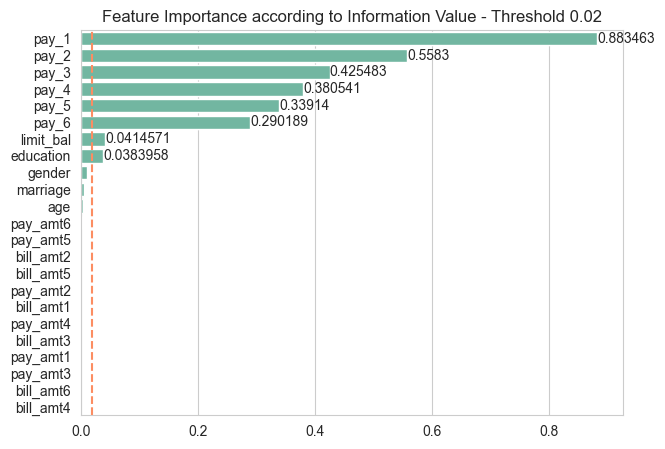

In [26]:
processor = Preprocessing(numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)])
train = processor.fit_transform(x_train.iloc[:, 1:], y_train)
iv = IVSelector(threshold=0.02)
iv.fit(train, y_train)
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
x = np.array(list(iv.information_value.values()))
y = np.array(list(iv.information_value.keys()))

chosen = sns.barplot(x=x[x > iv.threshold], y=y[:len(x[x > iv.threshold])], orient='y', color=sns.color_palette("Set2")[0])
ax = sns.barplot(x=iv.information_value.values(), y=iv.information_value.keys(), orient='y', color=sns.color_palette("Set2")[0])

chosen.bar_label(chosen.containers[0])
plt.axvline(x=iv.threshold, color=sns.color_palette("Set2")[1], linestyle='--')
plt.title("Feature Importance according to Information Value - Threshold 0.02")

In [22]:
# validation and testing
try:
    iv = pd.read_csv("../output/csv/phase_1/feature_selection/feature_selection.csv")
except:
    output = {"feature_selection": [], "selected_features": [], "roc_auc": [], "accuracy": [], "f1": [],
              "precision": [], "recall": [], "dataset": []}

    testcases = {"iv_selector": {"yes": IVSelector(), "no": None}}

    model = LogisticRegression(max_iter=1000)

    for select_option, selector in testcases['iv_selector'].items():
        processor = Preprocessing(scaler=StandardScaler(),
                                  encoder=WoEEncoder(fill_value=0.00001),
                                  numeric_into_bins= {"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40): "30-40",
                                                              (40, 50): "40-50", (50, 60): "50-60", (60, 100): "over 60"}},
                                  numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                                  specific_encoders={"gender": LabelEncoder()},
                                  feature_selector=selector)
        estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE())
        scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)
        output["dataset"].append("validation")
        output["feature_selection"].append(select_option)
        if select_option == "no":
            output["selected_features"].append("all")
        else:
            output["selected_features"].append(", ".join(processor.selector.get_feature_names_out()))
        for method, score in scores.items():
            output[method].append(score)
        scores = modelling_evaluation(x_train=x_train.iloc[:, 1:], y_train=y_train,
                                      x_test=x_test.iloc[:, 1:], y_test=y_test,
                                      estimator=estimator)
        output["dataset"].append("testing")
        output["feature_selection"].append(select_option)
        if select_option == "no":
            output["selected_features"].append("all")
        else:
            output["selected_features"].append(", ".join(processor.selector.get_feature_names_out()))
        for method, score in scores.items():
            output[method].append(score)
    iv = pd.DataFrame(output)
    iv.to_csv("../output/csv/phase_1/feature_selection/feature_selection.csv", index=False)

# Phase 2

### Tuning Parameters for Different Machine Learning Models

__Logistic Regression__

In [23]:
def objective_lr(trial):
    # Define hyperparameters to optimize
    penalty = trial.suggest_categorical('penalty', ['l2', None])
    C = trial.suggest_loguniform('C', 1e-4, 1e4)
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'sag', 'saga'])

    class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
    tol = trial.suggest_loguniform('tol', 1e-5, 1e-1)

    model = LogisticRegression(penalty=penalty, C=C, solver=solver, max_iter=1000, tol=tol,
                               class_weight=class_weight, random_state=42)
    
    processor = Preprocessing(scaler=StandardScaler(),
                              encoder=WoEEncoder(fill_value=0.00001),
                              numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                              numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                        "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                        (60, 100): "over 60"}},
                              specific_encoders={"gender": LabelEncoder()})

    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE(random_state=42))

    scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, methods=['f1'], estimator=estimator)
    f1 = scores['f1']

    return f1

try:
    lr = joblib.load("../models/best_logistic.pkl")
except:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_lr, n_trials=100)

    # Access the best hyperparameters and corresponding score
    best_params = study.best_params
    best_score = study.best_value

    print("Best parameters:", best_params)
    print("Best score:", best_score)

    model = LogisticRegression(**best_params, random_state=42, max_iter=1000)
    joblib.dump(model, '../models/best_logistic.pkl')

__KNN__

In [24]:
def objective_knn(trial):
    # Define hyperparameters to optimize
    n_neighbors = trial.suggest_int('n_neighbors', 1, 10)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan','cosine'])
    
    # Initialize KNN classifier
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
    
    processor = Preprocessing(scaler=StandardScaler(),
                              encoder=WoEEncoder(fill_value=0.00001),
                              numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                              numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                        "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                        (60, 100): "over 60"}},
                              specific_encoders={"gender": LabelEncoder()})

    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE(random_state=42))

    scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, methods=['f1'], estimator=estimator)
    f1 = scores['f1']

    return f1

try:
    knn = joblib.load("../models/best_knn.pkl")
except:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_knn, n_trials=100)

    # Access the best hyperparameters and corresponding score
    best_params = study.best_params
    best_score = study.best_value

    print("Best parameters:", best_params)
    print("Best score:", best_score)

    model = KNeighborsClassifier(**best_params)
    joblib.dump(model, '../models/best_knn.pkl')

__LightGBM__

In [27]:
def objective_lgbm(trial):
    # Define hyperparameters to optimize
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 2, 50),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "boosting_type": "gbdt",
        "verbosity": -1,
        "random_state": 42,
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 20),
        "learning_rate": trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        'max_depth': trial.suggest_int('max_depth', -1, 20),
    }
    
    # Initialize KNN classifier
    model = LGBMClassifier(**params, force_col_wise=True)
    
    processor = Preprocessing(scaler=StandardScaler(),
                              encoder=WoEEncoder(fill_value=0.00001),
                              numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                              numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                        "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                        (60, 100): "over 60"}},
                              specific_encoders={"gender": LabelEncoder()})

    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE(random_state=42))

    scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, methods=['f1'], estimator=estimator)
    f1 = scores['f1']

    return f1

try:
    lgbm = joblib.load("../models/best_lgbm.pkl")
except:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_lgbm, n_trials=100)

    # Access the best hyperparameters and corresponding score
    best_params = study.best_params
    best_score = study.best_value

    print("Best parameters:", best_params)
    print("Best score:", best_score)

    model = LGBMClassifier(**best_params, random_state=42, verbosity=-1, force_col_wise=True)
    joblib.dump(model, '../models/best_lgbm.pkl')

__Random Forest__

In [28]:
def objective_rf(trial):
    # Define hyperparameters to optimize
    params = {
        "max_features": trial.suggest_categorical(name="max_features", choices=['log2', 'sqrt']) ,
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        "min_samples_split": trial.suggest_int(name="min_samples_split", low=2, high=10),
        "min_samples_leaf": trial.suggest_int(name="min_samples_leaf", low=1, high=10)
    }
    
    # Initialize KNN classifier
    model = RandomForestClassifier(**params, random_state=42)
    
    processor = Preprocessing(scaler=StandardScaler(),
                              encoder=WoEEncoder(fill_value=0.00001),
                              numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                              numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                        "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                        (60, 100): "over 60"}},
                              specific_encoders={"gender": LabelEncoder()})

    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE(random_state=42))

    scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, methods=['f1'], estimator=estimator)
    f1 = scores['f1']

    return f1

try:
    rf = joblib.load("../models/best_randomforest.pkl")
except:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_rf, n_trials=100)

    # Access the best hyperparameters and corresponding score
    best_params = study.best_params
    best_score = study.best_value

    print("Best parameters:", best_params)
    print("Best score:", best_score)

    model = RandomForestClassifier(**best_params, random_state=42)
    joblib.dump(model, '../models/best_randomforest.pkl')

__XGBoost__

In [29]:
def objective_xgb(trial):
    # Define hyperparameters to optimize
    params = {
        "silent": 1,
        "random_state": 42,
        # use exact for small dataset.
        "tree_method": trial.suggest_categorical("tree_method", ["exact", "auto"]),
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
    }

    if params["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        params["max_depth"] = trial.suggest_int("max_depth", 1, 10)
        # minimum child weight, larger the term more conservative the tree.
        params["min_child_weight"] = trial.suggest_int("min_child_weight", 1, 10)
        params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if params["booster"] == "dart":
        params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        params["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        params["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    
    # Initialize KNN classifier
    model = XGBClassifier(**params)
    
    processor = Preprocessing(scaler=StandardScaler(),
                              encoder=WoEEncoder(fill_value=0.00001),
                              numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                              numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                        "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                        (60, 100): "over 60"}},
                              specific_encoders={"gender": LabelEncoder()})

    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE(random_state=42))

    scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, methods=['f1'], estimator=estimator)
    f1 = scores['f1']

    return f1

try:
    xgb = joblib.load("../models/best_xgb.pkl")
except:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_xgb, n_trials=100)

    # Access the best hyperparameters and corresponding score
    best_params = study.best_params
    best_score = study.best_value

    print("Best parameters:", best_params)
    print("Best score:", best_score)

    model = XGBClassifier(**best_params, random_state=42, silent=1)
    joblib.dump(model, '../models/best_xgb.pkl')

__Catboost__

In [30]:
def objective_cb(trial):
    # Define hyperparameters to optimize
    params = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "learning_rate": trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    # Initialize KNN classifier
    model = CatBoostClassifier(**params, iterations=100, silent=True)
    
    processor = Preprocessing(scaler=StandardScaler(),
                              encoder=WoEEncoder(fill_value=0.00001),
                              numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                              numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                        "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                        (60, 100): "over 60"}},
                              specific_encoders={"gender": LabelEncoder()})

    estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE(random_state=42))

    scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, methods=['f1'], estimator=estimator)
    f1 = scores['f1']

    return f1

try:
    cb = joblib.load("../models/best_catboost.pkl")
except:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_cb, n_trials=100)

    # Access the best hyperparameters and corresponding score
    best_params = study.best_params
    best_score = study.best_value

    print("Best parameters:", best_params)
    print("Best score:", best_score)

    model = CatBoostClassifier(**best_params, random_state=42, silent=True)
    joblib.dump(model, '../models/best_catboost.pkl')

### Models Comparison

__Validation__

In [41]:
try:
    valid_default = pd.read_csv("../output/csv/phase_2/valid_notune.csv")
except:
    output = {"model": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": [], 'model_status': []}

    models = {"LogisticRegression": LogisticRegression(max_iter=1000),
            "KNN": KNeighborsClassifier(),
            "RandomForest": RandomForestClassifier(),
            "LightGBM": LGBMClassifier(verbose=-1, random_state=42),
            "XGBoost": XGBClassifier(random_state=42),
            "Catboost": CatBoostClassifier(verbose=False, random_state=42)}
    processor = Preprocessing(scaler=MinMaxScaler(),
                            encoder=WoEEncoder(fill_value=0.00001),
                            numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                            numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                        "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                        (60, 100): "over 60"}},
                            specific_encoders={"gender": LabelEncoder()})
    for model_name, model in models.items():
        estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE(random_state=42))
        scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)
        output["model"].append(model_name)
        output["model_status"].append("no tuning")
        for method, score in scores.items():
            output[method].append(score)

    valid_default = pd.DataFrame(output)
    valid_default.to_csv("../output/csv/phase_2/valid_notune.csv", index=False)

In [40]:
try:
    valid_default = pd.read_csv("../output/csv/phase_2/valid_tuned.csv")
except:
    output = {"model": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": [], 'model_status': []}

    models = {"LogisticRegression": joblib.load("../models/best_logistic.pkl"),
            "KNN": joblib.load("../models/best_knn.pkl"),
            "RandomForest": joblib.load("../models/best_randomforest.pkl"),
            "LightGBM": joblib.load("../models/best_lgbm.pkl"),
            "XGBoost": joblib.load("../models/best_xgb.pkl"),
            "Catboost": joblib.load("../models/best_catboost.pkl")}
    processor = Preprocessing(scaler=MinMaxScaler(),
                            encoder=WoEEncoder(fill_value=0.00001),
                            numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                            numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                        "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                        (60, 100): "over 60"}},
                            specific_encoders={"gender": LabelEncoder()})
    for model_name, model in models.items():
        estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE(random_state=42))
        scores = cross_validation(X=x_train.iloc[:, 1:], y=y_train, estimator=estimator)
        output["model"].append(model_name)
        output["model_status"].append("no tuning")
        for method, score in scores.items():
            output[method].append(score)

    valid_tuned = pd.DataFrame(output)
    valid_tuned.to_csv("../output/csv/phase_2/valid_tuned.csv", index=False)

In [39]:
try:
    all_valid = pd.read_csv("../output/csv/phase_2/valid_all.csv")
except:
    all_valid = pd.concat([valid_default, valid_tuned], axis=0, ignore_index=True)
    all_valid.to_csv("../output/csv/phase_2/valid_all.csv", index = False)

__Testing__

In [38]:
try:
    valid_default = pd.read_csv("../output/csv/phase_2/testing_notune.csv")
except:
    output = {"model": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": [], 'model_status': []}

    models = {"LogisticRegression": LogisticRegression(max_iter=1000),
            "KNN": KNeighborsClassifier(),
            "RandomForest": RandomForestClassifier(),
            "LightGBM": LGBMClassifier(verbose=-1, random_state=42),
            "XGBoost": XGBClassifier(random_state=42),
            "Catboost": CatBoostClassifier(verbose=False, random_state=42)}
    processor = Preprocessing(scaler=MinMaxScaler(),
                            encoder=WoEEncoder(fill_value=0.00001),
                            numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                            numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                        "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                        (60, 100): "over 60"}},
                            specific_encoders={"gender": LabelEncoder()})
    for model_name, model in models.items():
        estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE(random_state=42))
        scores = modelling_evaluation(estimator=estimator,
                                      x_train=x_train.iloc[:, 1:], y_train=y_train,
                                      x_test=x_test.iloc[:, 1:], y_test=y_test)
        output["model"].append(model_name)
        output["model_status"].append("no tuning")
        for method, score in scores.items():
            output[method].append(score)

    valid_default = pd.DataFrame(output)
    valid_default.to_csv("../output/csv/phase_2/testing_notune.csv", index=False)

In [37]:
try:
    valid_default = pd.read_csv("../output/csv/phase_2/testing_tuned.csv")
except:
    output = {"model": [], "roc_auc": [], "accuracy": [], "f1": [], "precision": [], "recall": [], 'model_status': []}

    models = {"LogisticRegression": joblib.load("../models/best_logistic.pkl"),
            "KNN": joblib.load("../models/best_knn.pkl"),
            "RandomForest": joblib.load("../models/best_randomforest.pkl"),
            "LightGBM": joblib.load("../models/best_lgbm.pkl"),
            "XGBoost": joblib.load("../models/best_xgb.pkl"),
            "Catboost": joblib.load("../models/best_catboost.pkl")}
    processor = Preprocessing(scaler=MinMaxScaler(),
                            encoder=WoEEncoder(fill_value=0.00001),
                            numeric_to_object=[f"pay_{i}" for i in range(1, 7, 1)],
                            numeric_into_bins={"age": {(0, 20): "under 20", (20, 30): "20-30", (30, 40):
                                                        "30-40", (40, 50): "40-50", (50, 60): "50-60",
                                                        (60, 100): "over 60"}},
                            specific_encoders={"gender": LabelEncoder()})
    for model_name, model in models.items():
        estimator = DefaultPaymentClassifier(processor=processor, model=model, balance=SMOTE(random_state=42))
        scores = modelling_evaluation(estimator=estimator,
                                      x_train=x_train.iloc[:, 1:], y_train=y_train,
                                      x_test=x_test.iloc[:, 1:], y_test=y_test)
        output["model"].append(model_name)
        output["model_status"].append("no tuning")
        for method, score in scores.items():
            output[method].append(score)

    valid_tuned = pd.DataFrame(output)
    valid_tuned.to_csv("../output/csv/phase_2/testing_tuned.csv", index=False)

In [36]:
try:
    all_valid = pd.read_csv("../output/csv/phase_2/testing_all.csv")
except:
    all_valid = pd.concat([valid_default, valid_tuned], axis=0, ignore_index=True)
    all_valid.to_csv("../output/csv/phase_2/testing_all.csv", index = False)